#Assignment 2
#Author: Syed Kumayl Raza Moosavi - 364013

#The x and y coordination and the annotations are stored in .npy files. 
#Use Python numpy to read the files separated with a semi-colon.

#Expression: expression ID of the face 
#(0: Neutral, 1: Happy, 2: Sad, 3: Surprise, 4:Fear, 5: Disgust, 6: Anger, 7: Contempt)

#Valence: valence value of the expression in interval [-1,+1] (for Uncertain and Noface categories the value is -2)
    #Continuous values from -1 (negative/unpleasant) to +1 (positive/pleasant)
    
#Arousal: arousal value of the expression in interval [-1,+1] (for Uncertain and No-face categories the value is -2)
    #Continuous values from -1 (Tired) to +1 (Active)
    
#Task:
#----> Use appropriate CNN architecture recognition of Facial Expression, and computing Valence and Arousal
#----> use at least two CNN baselines (VGG, ResNet, Inception, Xception, MobileNet, EfficientNet, SE Net, DenseNet or any other … etc)

Part 2

Data is very large. So we will use a custom data generator to load batches of data from the files and then train on each batch simultaneously using the GPU of the computer

In [1]:
###With python 3.7 these two are compatible versions of tensorflow and cudatoolkit that will enable GPU from PC
#Create a new environment in anaconda for installing previous versions

#!pip install tensorflow==2.2
#!pip install cudatoolkit==10.1

#!pip install scikit-image
#!pip install pandas
#!pip install matplotlib
#!pip install krippendorff

#I have tensorflow 2.2 installed so compatible addon is:
#!pip install tensorflow-addons==0.11.2
#!pip install torch
#!pip install scikit-learn


import numpy as np
import os
import glob

import skimage.io as io
import pandas as pd
import cv2
import krippendorff
import torch

from matplotlib import pyplot as plt
import random
import tensorflow as tf
import pathlib
from matplotlib.patches import Circle
import cv2

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 30 21:34:45 2022

@author: moosa
"""

from pathlib import Path
import os
import random
from PIL import Image

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_folder, npy_folder, batch_size=29, shuffle=True, sampler='training', 
                 validation_split=True, validation_size=0.2):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_folder = img_folder
        self.npy_folder = npy_folder
        self.sampler = sampler
        self.validation_split = validation_split
        self.validation_size = validation_size
        
        
        aa = os.listdir(img_folder)
        x = (1-validation_size)*len(os.listdir(img_folder))
        y = validation_size*len(os.listdir(img_folder))
        x = round(x)
        y = round(y)
        train_x = aa[0:x]
        val_x = aa[x:len(os.listdir(img_folder))]
        
        if self.sampler == 'training':
            self.img_list = train_x
        elif self.sampler == 'validation':
            self.img_list = val_x
            
        self.indices = np.arange(0, len(self.img_list))
        if self.shuffle:
            random.shuffle(self.img_list)

    def __len__(self):
        return int(np.ceil(len(self.img_list) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size <= len(self.img_list):            
            index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        else:
            roll_over = (index + 1) * self.batch_size -  len(self.img_list)
            index = np.array(self.indices[index * self.batch_size:].tolist() + self.indices[0:roll_over+1].tolist())
        batch = [self.indices[k] for k in index]
        
        [X,X2], [y, y2, y3] = self.__get_data(batch)
        return [X,X2], [y, y2, y3]


    def __get_data(self, batch):
        
        X = []
        X2 = []
        y = []
        y2 = []
        y3 = []
        
        for i, id in enumerate(batch):
            img_name = self.img_list[id]
            aro = np.load(os.path.join(self.npy_folder, Path(img_name).stem+'_aro.npy')).astype('float32')
            expa = np.load(os.path.join(self.npy_folder, Path(img_name).stem+'_exp.npy'))
            exp = to_categorical(expa,num_classes = 8)
            lnd = np.load(os.path.join(self.npy_folder, Path(img_name).stem+'_lnd.npy')).reshape(68,2)
            val = np.load(os.path.join(self.npy_folder, Path(img_name).stem+'_val.npy')).astype('float32')
            
            img = Image.open(os.path.join(self.img_folder,img_name)).convert('RGB')
            img = tf.keras.preprocessing.image.img_to_array(img)
            X.append((img))
            X2.append((lnd))
            y.append((aro))
            y2.append((val))
            y3.append((exp))            
        return [np.array(X),np.array(X2)], [np.array(y),np.array(y2),np.array(y3)]


In [3]:
def show(xx,yy,y1,y2,y3): 
    fig,ax = plt.subplots(1)
    #ax.set_aspect('equal')
    plt.imshow(xx.astype("uint8"))
    ax.text(5, 5, y3, bbox={'facecolor': 'white', 'pad': 10})
    
    #ax.text(5, 200, 'Arousal: 'y1, bbox={'facecolor': 'white', 'pad': 10})
    plt.scatter(yy[:, 0], yy[:, 1], s=10, marker='.')
    plt.pause(0.001)  # pause a bit so that plots are updated

7936
Arousal : 0.0229674 Valence : 0.558873


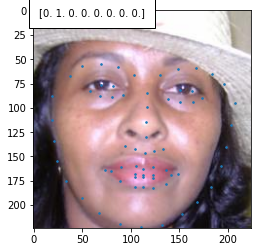

Arousal : -0.014518 Valence : 0.0


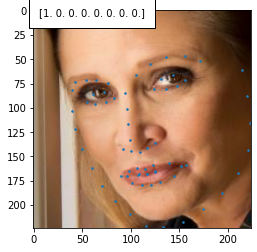

Arousal : 0.0860585 Valence : 0.494836


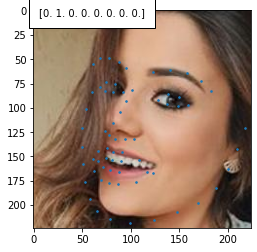

Arousal : -0.147493 Valence : 0.358196


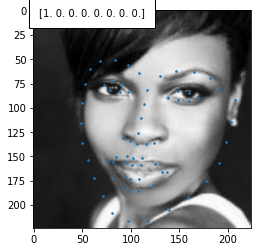

Arousal : -0.116144 Valence : 0.614595


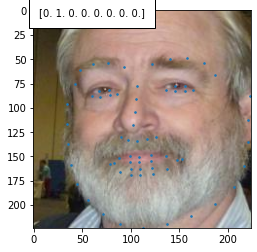

In [24]:
from tensorflow.keras.utils import to_categorical
#using data generators for training of models
data = DataGenerator('train_and_val_set-002/train_set/images', 'train_and_val_set-002/train_set/annotations', 
                     batch_size=29, sampler='training', validation_split=True, validation_size=0.2)

print(len(data))
i=0
for X,y in data:
    i=i+1
    print("Arousal :", y[0][0],"Valence :", y[1][0])
    show(X[0][0],X[1][0],y[0][0],y[1][0],y[2][0])
    
    #See random images with landmarks for 5 values then break generator
    if i==5:
        break

In [5]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def correlationMetric(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = K.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def CCC(y_true, y_pred):
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    
    The concordance correlation coefficient is the correlation between two variables that fall on the 45 degree line through the origin.
    
    It is a product of
    - precision (Pearson correlation coefficient) and
    - accuracy (closeness to 45 degree line)

    Interpretation:
    - `rho_c =  1` : perfect agreement
    - `rho_c =  0` : no agreement
    - `rho_c = -1` : perfect disagreement 
    
    Args: 
    - y_true: ground truth
    - y_pred: predicted values
    
    Returns:
    - concordance correlation coefficient (float)
    '''
    
    # covariance between y_true and y_pred
    N = K.int_shape(y_pred)[-1]
    s_xy = 1.0 / (N - 1.0 + K.epsilon()) * K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    # means
    x_m = K.mean(y_true)
    y_m = K.mean(y_pred)
    # variances
    s_x_sq = K.var(y_true)
    s_y_sq = K.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC


############Needed to install old version of tensorflow to activate the GPU of the computer. Took a long time to figure that out
############After installing old version of tensorflow cannot find compatible version of tensorflow-addons for these metrics

import tensorflow_addons as tfa
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient as CORR
from tensorflow_addons.metrics import CohenKappa as Cohen_Kappa
from tensorflow_addons.metrics import F1Score as F1_Score

Apply a Network and predict classification using image and landmark points according to the following model
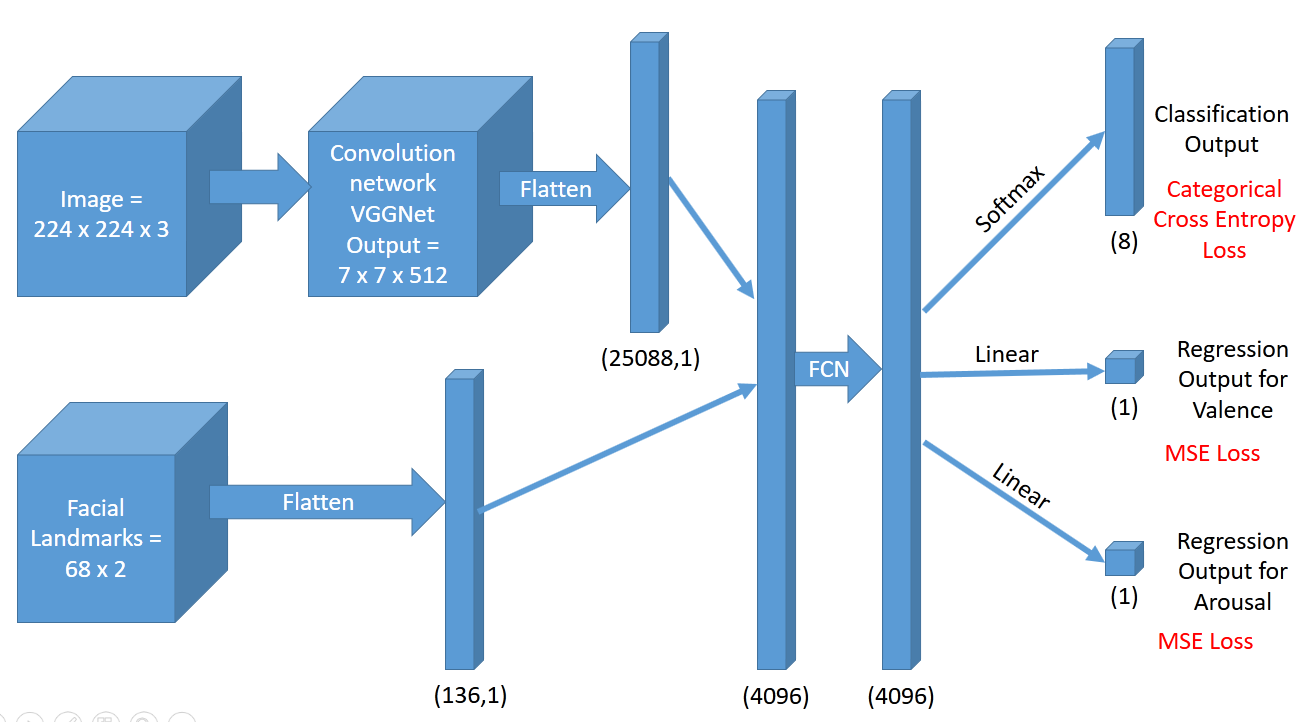

In [7]:
# Creating a CNN model with many VGG blocks

# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in
 
# define model input
visible = Input(shape=(224, 224, 3))  #image
visible2 = Input(shape=(68, 2))   #expressions


# add vgg module
layer1 = vgg_block(visible, 64, 2)
# add vgg module
layer2 = vgg_block(layer1, 128, 2)
# add vgg module
layer3 = vgg_block(layer2, 256, 3)
# add vgg module
layer4 = vgg_block(layer3, 512, 3)
# add vgg module
layer5 = vgg_block(layer4, 512, 3)

layer6_1 = Flatten()(layer5)
layer6_2 = Flatten()(visible2)

layer6 = concatenate([layer6_1, layer6_2])
layer7 = Dense(4096, activation='relu')(layer6)
layer8 = Dense(4096, activation='relu')(layer7)


# Output layer for classification (1000 classes)
layer_class = Dense(8, activation='softmax')(layer8)


layer_arousal = Dense(1, activation='linear')(layer8)

layer_val = Dense(1, activation='linear')(layer8)


classification_output = Lambda(lambda x:x, name = "classification_output")(layer_class)
arousal_output = Lambda(lambda x:x, name = "arousal_output")(layer_arousal)
valence_output = Lambda(lambda x:x, name = "valence_output")(layer_val)

# create model
model = Model(inputs=[visible,visible2], outputs=[arousal_output, valence_output, classification_output])


#macro parameters
model.compile(loss=['categorical_crossentropy', 'mse', 'mse'],
              optimizer='adam', metrics={"classification_output":['accuracy',
                                                                  Cohen_Kappa(num_classes=8),
                                                                  F1_Score(num_classes=8),
                                                                  AUC(curve='ROC',name = 'AUC-ROC'), 
                                                                  AUC(curve='PR',name = 'AUC-PR')], 
                                         "arousal_output":['RootMeanSquaredError',
                                                          correlationMetric, 
                                                           CCC], 
                                         "valence_output":['RootMeanSquaredError',
                                                          correlationMetric,
                                                           CCC]}, 
              run_eagerly=True)



# summarize model
model.summary()
# plot model architecture
#plot_model(model, show_shapes=True, to_file='vgg_block.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
#[print(i.shape, i.dtype) for i in model.inputs]
#[print(o.shape, o.dtype) for o in model.outputs]
#[print(l.name, l.input_shape, l.dtype) for l in model.layers]

In [9]:
import tensorflow as tf
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
model.fit_generator(generator=DataGenerator('train_and_val_set-002/train_set/images', 'train_and_val_set-002/train_set/annotations', 
                     batch_size=29, sampler='training', validation_split=True, validation_size=0.2), 
                    validation_data = DataGenerator('train_and_val_set-002/train_set/images', 'train_and_val_set-002/train_set/annotations', 
                     batch_size=29, sampler='validation', validation_split=True, validation_size=0.2),
                    use_multiprocessing=False, epochs = 10)

Epoch 1/10
111/111 [==============================] - 80s 721ms/step - loss: 408.0248 - arousal_output_loss: 4.1891e-08 - valence_output_loss: 407.8059 - classification_output_loss: 0.2189 - arousal_output_root_mean_squared_error: 145.6282 - arousal_output_correlationMetric: 1.0641 - arousal_output_CCC: -2617.5515 - valence_output_root_mean_squared_error: 20.1942 - valence_output_correlationMetric: 0.9727 - valence_output_CCC: 1983427.3750 - classification_output_accuracy: 0.1245 - classification_output_cohen_kappa: 0.0000e+00 - classification_output_f1_score: 0.0277 - classification_output_AUC-ROC: 0.4997 - classification_output_AUC-PR: 0.1249 - val_loss: 1.0564 - val_arousal_output_loss: 4.3325e-08 - val_valence_output_loss: 0.8380 - val_classification_output_loss: 0.2183 - val_arousal_output_root_mean_squared_error: 145.1927 - val_arousal_output_correlationMetric: 0.9596 - val_arousal_output_CCC: 2025.2971 - val_valence_output_root_mean_squared_error: 0.9154 - val_valence_output_cor

111/111 [==============================] - 83s 748ms/step - loss: 1.5258 - arousal_output_loss: 4.1891e-08 - valence_output_loss: 1.3070 - classification_output_loss: 0.2189 - arousal_output_root_mean_squared_error: 89.2167 - arousal_output_correlationMetric: 1.0594 - arousal_output_CCC: -3890.8625 - valence_output_root_mean_squared_error: 1.1432 - valence_output_correlationMetric: 1.0359 - valence_output_CCC: -8064829.0000 - classification_output_accuracy: 0.1245 - classification_output_cohen_kappa: 0.0000e+00 - classification_output_f1_score: 0.0277 - classification_output_AUC-ROC: 0.4997 - classification_output_AUC-PR: 0.1249 - val_loss: 1.4781 - val_arousal_output_loss: 4.3325e-08 - val_valence_output_loss: 1.2598 - val_classification_output_loss: 0.2183 - val_arousal_output_root_mean_squared_error: 89.2188 - val_arousal_output_correlationMetric: 0.9657 - val_arousal_output_CCC: 2816.3328 - val_valence_output_root_mean_squared_error: 1.1224 - val_valence_output_correlationMetric: 1

In [19]:
Test_evaluation = model.evaluate_generator(generator=DataGenerator('test_set/val_set/images', 'test_set/val_set/annotations', batch_size=29),
                    use_multiprocessing=False)

In [22]:
print('Overall Loss =', Test_evaluation[0])
print('arousal_output_loss =', Test_evaluation[1])
print('valence_output_loss =', Test_evaluation[2])
print('classification_output_loss =', Test_evaluation[3])
print('arousal_output_root_mean_squared_error =', Test_evaluation[4])
print('arousal_output_correlationMetric =', Test_evaluation[5])
print('arousal_output_CCC =', Test_evaluation[6])
print('valence_output_root_mean_squared_error =', Test_evaluation[7])
print('valence_output_correlationMetric =', Test_evaluation[8])
print('valence_output_CCC =', Test_evaluation[9])
print('classification_output_accuracy =', Test_evaluation[10])
print('classification_output_cohen_kappa =', Test_evaluation[11])
print('classification_output_f1_score =', Test_evaluation[12])
print('classification_output_AUC-ROC =', Test_evaluation[13])
print('classification_output_AUC-PR =', Test_evaluation[14])

Overall Loss = 0.8353999257087708
arousal_output_loss = 4.176726520199736e-08
valence_output_loss = 0.6166887283325195
classification_output_loss = 0.21871118247509003
arousal_output_root_mean_squared_error = 89.2086181640625
arousal_output_correlationMetric = 1.0612457990646362
arousal_output_CCC = -4442.6640625
valence_output_root_mean_squared_error = 0.785295307636261
valence_output_correlationMetric = 1.0590102672576904
valence_output_CCC = -15288396.0
classification_output_accuracy = 0.1251552850008011
classification_output_cohen_kappa = 0.0
classification_output_f1_score = [0.         0.         0.         0.22246757 0.         0.
 0.         0.        ]
classification_output_AUC-ROC = 0.5000887513160706
classification_output_AUC-PR = 0.12504614889621735
